# Projet 03 : Préparez des données pour un organisme de santé publique
***

**Contexte** : L'agence "Santé publique France" a lancé un appel à projets pour rendre les données de santé plus accessibles. L’agence souhaite faire explorer et visualiser des données, pour que ses agents puissent les exploiter.  
**Projet** : Rendre les données de santé plus accessibles. J'ai à ma disposition un jeu de données sur différents produits de consommation issu du site openFoodFacts.  
**Objectif** : concevoir une application userfriendly pour informer les consommateurs.

***
# I) Démarche méthodologique d'analyse de données

Ma démarche s’articule autour de 3 phases : 
 - l’élaboration d’un dataset d’étude : filtrage et nettoyage, permettant d’obtenir un dataset d’étude propre pour l’analyse
 - les différents types d’analyse du dataset : univariée pour la compréhension et multivariée pour la problématique, permettant d’avoir des bonnes données d’entrée pour les modèles.
 - la conception de l’application : étude des modèles et création du prototype, permettant de livrer un prototype fonctionnel

# II) Méthodes du projet

## Méthodes pour le nettoyage des données

In [1]:
# pour filtrer les colonnes en fonction de leur taux de valeurs manquantes
def filter_col_by_mising_data_pct(df, pct_min=0, pct_max=100):
    result = pd.DataFrame()
    print("Le DataFrame à filtrer présente", len(df), "lignes et", len(df.columns), "colonnes.")
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    print("La méthode va renvoyer un DataFrame présentant uniquement les colonnes ayant une part de valeurs manquantes allant de", pct_min, "% inclu à", pct_max, "% exclu.")
    # extraction des colonnes remplissant la condition de filtrage
    tot_list_col = round(df.isnull().mean()*100, 4).sort_values(ascending=False)
    tot_list_col = pd.DataFrame(tot_list_col, columns = ["%"])
    remain_list_col = tot_list_col.loc[(tot_list_col["%"] >= pct_min) & (tot_list_col["%"] < pct_max), :]
    nb_col_remained = len(remain_list_col)
    nb_col_removed = len(tot_list_col) - nb_col_remained
    print("Après filtrage, il reste", nb_col_remained, "colonnes dans le DataFrame.")
    print("Il y a eu suppression de", nb_col_removed, "colonnes, soit", round(nb_col_removed/len(tot_list_col)*100, 2), "% des colonnes.")
    
    # test sur le nb de colonnes restantes
    if len(remain_list_col) == 0:
        print("Le filtre est trop bas. Il n'y a plus de colonnes à exploiter.")
        return result
    
    # renvoyer le même dataset avec uniquement les colonnes filtrées
    result = df[remain_list_col.index]
    return result

In [2]:
# pour supprimer les colonnes vides en passant par la méthode de filtre en fonction du taux de valeurs manquantes
def remove_empty_columns(df):
    result = pd.DataFrame()
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    print("Appel de la méthode filter_col_by_mising_data_pct() pour supprimer les colonnes vides.")
    result = filter_col_by_mising_data_pct(df)
    return result    

In [3]:
# pour séparer les colonnes par type de donnée
def split_data_num_categ(df):
    result = []
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    dict_col = {
        'numeric': [],
        'category': [],
        'boolean': [],
        'datetime': [],
        'deltatime': []
    }
    
    for col in df.columns:
        if df[col].dtype.name in ('float64', 'int64'):
            dict_col['numeric'].append(col)
        elif df[col].dtype.name in ('object', 'category'):
            dict_col['category'].append(col)
        elif df[col].dtype.name == 'bool':
            dict_col['boolean'].append(col)
        elif df[col].dtype.name == 'datetime64':
            dict_col['datetime'].append(col)
        elif df[col].dtype.name == 'timedelta[ns]':
            dict_col['deltatime'].append(col)
        else:
            print("Type de données non connu :", df[col].dtype.name, "pour la colonne", col)

    print("Voici la répartition des colonnes par type de données :")
    for key, value in dict_col.items():
        nb_col_by_type = len(value)
        print(key, ":", nb_col_by_type, "colonnes.")
        if nb_col_by_type > 0:
            result.append(df[value])
    
    return result

## Méthodes pour l'ACP

In [4]:
# pour utiliser la méthode du PCA et afficher l'éboulis des inerties entre les variables
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
def compute_pca(df, n_components=2):
    result = pd.DataFrame()
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    # split des données
    X = df.values
    names = df.index
    features = df.columns
    
    print("L'échantillon présente", df.shape[0], "lignes et", df.shape[1], "colonnes")
    # vérif n_components
    if n_components > min(len(df), len(features)):
        print("Le nombre de composantes est trop élevée. On le recale à la valeur maximale.")
        print("La nouvelle valeur sera le minimum entre le nombre de ligne dans l'échantillon et le nombre de features, càd", min(len(df), len(features)))
        n_components = min(len(df), len(features))
    
    scaler = StandardScaler() # instance de scaler
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA(n_components=n_components) # instance de PCA
    pca.fit(X_scaled) # entrainement sur les données scalées
    
    # print("Valeurs propres (mieux si > 1):", pca.explained_variance_)
    print("Une méthode consiste à dire que l'on garde uniquement les valeurs propres supérieures à 1.")
    nb_opti_val_p = [x for x in pca.explained_variance_ if x >= 0.9]
    print("Ici, la méthode des valeurs propres nous demande de garder", len(nb_opti_val_p), "composantes.")
    # print("Variance ratio", pca.explained_variance_ratio_)
    
    # tracé de l'éboulis des valeurs propres
    scree = (pca.explained_variance_ratio_*100).round(2)
    scree_cum = scree.cumsum().round()
    print("La méthode principale consiste à dire que l'on garde uniquement les composantes qui regroupent 95% des variables.")
    nb_opti_95_inertie = len([x for x in scree_cum if x <= 95])
    print("Ici, la méthode des 95% d'inertie nous demande de garder", nb_opti_95_inertie, "composantes.")
    
    x_list = range(1, n_components+1)
    plt.bar(x_list, scree)
    plt.plot(x_list, scree_cum, c="red", marker='o')
    plt.xticks(np.arange(0, n_components+1, 2))
    plt.xlabel("Rang de l'axe d'inertie")
    plt.ylabel("Pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    
    # pour afficher les lignes de 95% et de nombre de composantes optimal
    min_ylim, max_ylim = plt.ylim()
    min_xlim, max_xlim = plt.xlim()
    plt.axvline(nb_opti_95_inertie, color='k', linestyle='dashed', linewidth=1)
    plt.text(nb_opti_95_inertie, max_ylim*0.85, ' {:.0f} composantes'.format(nb_opti_95_inertie))
    plt.axhline(95, color='k', linestyle='dashed', linewidth=1)
    plt.text(max_xlim*0.55, 95+2, "95 % d'inertie")
    
    plt.show(block=False)
    
    return pca

In [5]:
def show_components_heatmap(df, pca):
    result = pd.DataFrame()
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    pcs = pca.components_
    pcs = pd.DataFrame(pcs)
    pcs.columns = df.columns # features
    n_components = len(pcs)
    x_list = range(1, n_components+1)
    pcs.index = [f"F{i}" for i in x_list]
    pcs.round(2)
    # représentation visuelle
    gif, ax = plt.subplots(figsize=(20, 10))
    sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")
    return pcs


In [6]:
def compute_components(pcs, threshold=0.6):
    result = []
    for index, row in pcs.iterrows():
        for col in pcs.columns:
            if abs(row[col]) >= threshold:
                print(col, ":", row[col])
                result.append(col)
    
    result = list(set(result))
    print("Il y a", len(result), "variables ayant un impact conséquent sur les composantes.")
    print("Voici la liste :", result)
    return result

## Méthode pour ANOVA

In [7]:
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

## Méthode pour affichage personnalisé

In [8]:
# pour les pie charts, pour afficher les pourcentages et les libellés uniquement avec le taux > limit_perc%
limit_perc = 5
def show_perc(pct):
    return ('%.1f%%' % pct) if pct > limit_perc else ''

def show_labels(data):
    list = []
    for val, cnt in data.items():
        if (cnt*100/np.sum(data)) > limit_perc :
            list.append(val)
        else:
            list.append('')
    return list

***
# III) Présentation générale du jeu de données

## 1) Exploration du dataset

### a) Imports

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from math import sqrt
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import neighbors
from sklearn.metrics import r2_score
# sns.set()

### b) Chargement du dataset

Il y avait un problème de données à cheval sur plusieurs lignes. Un script a permis de corriger le problème. Voici le fichier corrigé en entrée.

In [10]:
# Le séparateur dans le dataset est la tabulation
raw_data = pd.read_csv("fr.openfoodfacts.org.products_c1.csv", encoding='utf-8', sep='\t')

/tmp/ipykernel_9947/2650904854.py:2: DtypeWarning: Columns (0,19,20,24,25,26,28,35,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv("fr.openfoodfacts.org.products_c1.csv", encoding='utf-8', sep='\t')


In [11]:
print("Le dataset brut présente", raw_data.shape[0], "lignes et", raw_data.shape[1], "colonnes")
raw_data.head()

Le dataset brut présente 320749 lignes et 162 colonnes


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


***
## 2) Traitement de réduction et de sélection des données

Le dataset présente énormément de colonnes et de lignes. Nous voulons le réduire pour faciliter son exploitation.  
Avant même de commencer à imputer des valeurs en traitant les valeurs manquantes et les outliers, nous allons effectuer différents filtrages de lignes et de colonnes.

### a) Suppression colonnes vides

Tout d'abord, nous effectuons un premier filtrage pour supprimer toutes les colonnes vides.

In [12]:
# On supprime les colonnes vides
data_wo_col_vide = remove_empty_columns(raw_data)

Appel de la méthode filter_col_by_mising_data_pct() pour supprimer les colonnes vides.
Le DataFrame à filtrer présente 320749 lignes et 162 colonnes.
La méthode va renvoyer un DataFrame présentant uniquement les colonnes ayant une part de valeurs manquantes allant de 0 % inclu à 100 % exclu.
Après filtrage, il reste 141 colonnes dans le DataFrame.
Il y a eu suppression de 21 colonnes, soit 12.96 % des colonnes.


In [13]:
print("Une fois les colonnes vides supprimées du dataset brut, il reste", data_wo_col_vide.shape[0], "lignes et", data_wo_col_vide.shape[1], "colonnes")

Une fois les colonnes vides supprimées du dataset brut, il reste 320749 lignes et 141 colonnes


### b) Séparation des colonnes par type de données

In [14]:
# On regarde la répartition des colonnes en fonction de leur type
data_num, data_categ = split_data_num_categ(data_wo_col_vide)

Voici la répartition des colonnes par type de données :
numeric : 89 colonnes.
category : 52 colonnes.
boolean : 0 colonnes.
datetime : 0 colonnes.
deltatime : 0 colonnes.


In [15]:
print("Le dataset est réparti comme suit :")
print("Colonnes de type numérique :", len(data_num.columns), "soit,", round(len(data_num.columns)/len(data_wo_col_vide.columns)*100, 1), "% des colonnes du dataset intermédiaire.")
print("Colonnes de type catégoriel :", len(data_categ.columns), "soit,", round(len(data_categ.columns)/len(data_wo_col_vide.columns)*100, 1), "% des colonnes du dataset intermédiaire.")

Le dataset est réparti comme suit :
Colonnes de type numérique : 89 soit, 63.1 % des colonnes du dataset intermédiaire.
Colonnes de type catégoriel : 52 soit, 36.9 % des colonnes du dataset intermédiaire.


### c) Suppression lignes target vides

Ensuite nous avons choisi d'avoir une approche métier et technique de ce dataset. Notre objectif est de qualifier la qualité des produits. A ce stade de l'étude, nous ne savons pas encore quel modèle nous utiliserons. Cependant, une première analyse du dataset nous permet d'identifier 2 targets possibles : `nutrition-score-fr_100g` et `nutrition_grade_fr`. Sans cette donnée, nous ne pouvons pas entraîner nos modèles. Nous allons donc supprimer toutes les lignes n'ayant pas les targets de renseignées.

In [16]:
# le nutriscore sera notre target, donc on peut supprimer toutes les lignes n'ayant pas de nutriscore renseigné
data_w_target = data_wo_col_vide.loc[(data_wo_col_vide["nutrition-score-fr_100g"].notnull()) | (data_wo_col_vide["nutrition_grade_fr"].notnull()), :]
print("Il y a", raw_data.shape[0] - data_w_target.shape[0], "lignes sans Nutri-Score ou Nutri-Grade de renseigné, soit", round((1-data_w_target.shape[0]/raw_data.shape[0])*100, 2), "% des données.")

Il y a 99516 lignes sans Nutri-Score ou Nutri-Grade de renseigné, soit 31.03 % des données.


In [17]:
data_w_target.reset_index(drop=True)

,myristic-acid_100g,palmitic-acid_100g,stearic-acid_100g,arachidic-acid_100g,montanic-acid_100g,caprylic-acid_100g,gamma-linolenic-acid_100g,capric-acid_100g,lauric-acid_100g,maltose_100g,...,creator,created_datetime,url,states,last_modified_datetime,last_modified_t,created_t,states_tags,states_fr,code
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,usda-ndb-import,2017-03-09T14:32:37Z,http://world-fr.openfoodfacts.org/produit/0000...,"en:to-be-completed, en:nutrition-facts-complet...",2017-03-09T14:32:37Z,1489069957,1489069957,"en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",4530
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,usda-ndb-import,2017-03-09T14:32:37Z,http://world-fr.openfoodfacts.org/produit/0000...,"en:to-be-completed, en:nutrition-facts-complet...",2017-03-09T14:32:37Z,1489069957,1489069957,"en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",4559
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,usda-ndb-import,2017-03-09T10:35:31Z,http://world-fr.openfoodfacts.org/produit/0000...,"en:to-be-completed, en:nutrition-facts-complet...",2017-03-09T10:35:31Z,1489055731,1489055731,"en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",16087
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,usda-ndb-import,2017-03-09T10:35:11Z,http://world-fr.openfoodfacts.org/produit/0000...,"en:to-be-completed, en:nutrition-facts-complet...",2017-03-09T10:35:12Z,1489055712,1489055711,"en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",16124
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,usda-ndb-import,2017-03-09T10:34:10Z,http://world-fr.openfoodfacts.org/produit/0000...,"en:to-be-completed, en:nutrition-facts-complet...",2017-03-09T10:34:11Z,1489055651,1489055650,"en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",16872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,usda-ndb-import,2017-03-09T20:45:00Z,http://world-fr.openfoodfacts.org/produit/9787...,"en:to-be-completed, en:nutrition-facts-complet...",2017-03-09T20:45:00Z,1489092300,1489092300,"en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",9787461062105
221229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,drmalabar,2015-07-25T09:47:06Z,http://world-fr.openfoodfacts.org/produit/9847...,"en:to-be-completed, en:nutrition-facts-complet...",2015-09-14T13:37:28Z,1442237848,1437817626,"en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",9847548283004
221230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,kiliweb,2017-04-01T20:52:18Z,http://world-fr.openfoodfacts.org/produit/9900...,"en:to-be-completed, en:nutrition-facts-complet...",2017-04-01T20:52:19Z,1491079939,1491079938,"en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",9900000000233
221231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,balooval,2013-04-28T15:30:39Z,http://world-fr.openfoodfacts.org/produit/9911...,"en:to-be-checked, en:complete, en:nutrition-fa...",2013-06-20T01:09:16Z,1371690556,1367163039,"en:to-be-checked,en:complete,en:nutrition-fact...","A vérifier,Complet,Informations nutritionnelle...",99111250


In [18]:
print("Une fois les lignes de target vides supprimées du dataset, il reste", data_w_target.shape[0], "lignes et", data_w_target.shape[1], "colonnes")

Une fois les lignes de target vides supprimées du dataset, il reste 221233 lignes et 141 colonnes


### d) Suppression colonnes peu renseignées

Comme nous le voyons, il y a encore beaucoup de colonnes dans ce dataset pour notre étude. Regardons maintenant la répartition des colonnes en fonction du taux de valeurs manquantes.

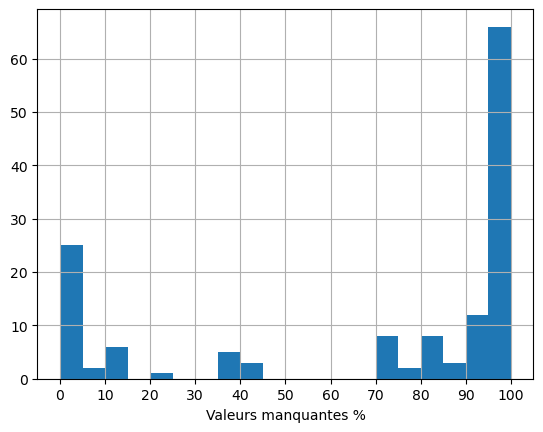

In [19]:
# on regarde la répartition des colonnes en fonction de la part de valeurs manquantes
valeurs_manquantes = round(data_w_target.isnull().mean()*100, 4).sort_values(ascending=False)
missing_val_df = pd.DataFrame(valeurs_manquantes, columns = ["%"])
missing_val_df["%"].hist(bins=20)
plt.xlabel("Valeurs manquantes %")
min_ylim, max_ylim = plt.ylim()
plt.xticks(np.arange(0, 101, 10))
plt.show()

In [20]:
miss_val_inf_5 = missing_val_df.loc[missing_val_df["%"]<=5, :]
print("Les colonnes ayant moins de 5 % de valeurs manquantes sont au nombre de", len(miss_val_inf_5), "soit,", round(len(miss_val_inf_5)/raw_data.shape[1]*100, 1), "% des colonnes.")
miss_val_sup_95 = missing_val_df.loc[missing_val_df["%"]>=95, :]
print("Les colonnes ayant plus de 95 % de valeurs manquantes sont au nombre de", len(miss_val_sup_95), "soit,", round(len(miss_val_sup_95)/raw_data.shape[1]*100, 1), "% des colonnes.")

Les colonnes ayant moins de 5 % de valeurs manquantes sont au nombre de 25 soit, 15.4 % des colonnes.
Les colonnes ayant plus de 95 % de valeurs manquantes sont au nombre de 66 soit, 40.7 % des colonnes.


En étudiant les colonnes, j'ai choisi une limite de taux de valeurs manquantes à 99.3%. En effet, dans les colonnes au-delà de ce taux, je n'ai pas remarqué d'intérêt pour notre étude.

In [21]:
pct_miss_val_keep = 99.3
miss_val_90 = missing_val_df.loc[missing_val_df["%"]>pct_miss_val_keep, :]
print("Les colonnes ayant plus de", pct_miss_val_keep, "% de valeurs manquantes sont au nombre de", len(miss_val_90), "soit,", round(len(miss_val_90)/data_w_target.shape[1]*100, 1), "% des colonnes.")

Les colonnes ayant plus de 99.3 % de valeurs manquantes sont au nombre de 49 soit, 34.8 % des colonnes.


In [22]:
# On supprime les colonnes ayant plus de 99% de valeurs manquantes
data_filt_90p = filter_col_by_mising_data_pct(data_w_target, pct_min=0, pct_max=pct_miss_val_keep)

Le DataFrame à filtrer présente 221233 lignes et 141 colonnes.
La méthode va renvoyer un DataFrame présentant uniquement les colonnes ayant une part de valeurs manquantes allant de 0 % inclu à 99.3 % exclu.
Après filtrage, il reste 92 colonnes dans le DataFrame.
Il y a eu suppression de 49 colonnes, soit 34.75 % des colonnes.


In [23]:
print("Une fois les colonnes peu renseignées supprimées du dataset, il reste", data_filt_90p.shape[0], "lignes et", data_filt_90p.shape[1], "colonnes")

Une fois les colonnes peu renseignées supprimées du dataset, il reste 221233 lignes et 92 colonnes


### e) Sélection des variables catégorielles pertinentes

Il reste encore beaucoup de colonnes. Il nous faut avoir une différente approche en sélectionnant les variables pertinentes dans celles restantes. Regardons d'abord les variables catégorielles.

In [24]:
# On regarde la répartition des colonnes en fonction de leur type
data_num, data_categ = split_data_num_categ(data_filt_90p)

Voici la répartition des colonnes par type de données :
numeric : 40 colonnes.
category : 52 colonnes.
boolean : 0 colonnes.
datetime : 0 colonnes.
deltatime : 0 colonnes.


In [25]:
# regardons la liste des colonnes catégorielles
print(data_categ.columns)

Index(['ingredients_from_palm_oil_tags',
       'ingredients_that_may_be_from_palm_oil_tags', 'origins_tags', 'origins',
       'first_packaging_code_geo', 'cities_tags', 'traces_tags', 'traces_fr',
       'traces', 'emb_codes_tags', 'emb_codes', 'allergens',
       'manufacturing_places_tags', 'manufacturing_places', 'labels',
       'labels_tags', 'labels_fr', 'stores', 'generic_name', 'purchase_places',
       'image_small_url', 'image_url', 'packaging', 'packaging_tags',
       'main_category_fr', 'categories', 'categories_tags', 'categories_fr',
       'main_category', 'pnns_groups_1', 'pnns_groups_2', 'quantity',
       'additives_tags', 'additives_fr', 'serving_size', 'additives',
       'ingredients_text', 'brands_tags', 'brands', 'product_name',
       'countries_tags', 'countries_fr', 'countries', 'created_datetime',
       'creator', 'nutrition_grade_fr', 'url', 'states',
       'last_modified_datetime', 'states_tags', 'states_fr', 'code'],
      dtype='object')


Toujours dans notre approche métier, nous devons qualifier la qualité des produits. Il n'y a qu'une variable catégorielle le permettant, c'est `nutrition_grade_fr`. Elle nous servira de target pour certains algorithmes.  
Nous allons également sélectionner les colonnes `code` et `product_name` car elle nous permettront d'identifier les produits.

In [26]:
# liste des colonnes catégorielles à supprimer
col_categ_to_select = ['nutrition_grade_fr', 'code', 'product_name']
print("Sélection de", len(col_categ_to_select), "colonnes catégorielles pertinentes soit,", round(len(col_categ_to_select)/len(data_filt_90p.columns)*100, 1), "% des colonnes.")
col_categ_to_drop = [x for x in data_categ.columns if x not in col_categ_to_select]
print("Suppression de", len(col_categ_to_drop), "colonnes catégorielles non pertinentes soit,", round(len(col_categ_to_drop)/len(data_filt_90p.columns)*100, 1), "% des colonnes.")

Sélection de 3 colonnes catégorielles pertinentes soit, 3.3 % des colonnes.
Suppression de 49 colonnes catégorielles non pertinentes soit, 53.3 % des colonnes.


In [27]:
# suppression des colonnes categ
data_drop_categ = data_filt_90p.drop(col_categ_to_drop, axis=1)

In [28]:
print("Une fois les colonnes catégorielles sélectionnées, il reste", data_drop_categ.shape[0], "lignes et", data_drop_categ.shape[1], "colonnes")

Une fois les colonnes catégorielles sélectionnées, il reste 221233 lignes et 43 colonnes


### f) Sélection des variables numériques

In [29]:
# regardons la liste des colonnes numériques
print(data_num.columns)

Index(['alcohol_100g', 'pantothenic-acid_100g', 'copper_100g', 'folates_100g',
       'fruits-vegetables-nuts_100g', 'zinc_100g', 'vitamin-b12_100g',
       'vitamin-b9_100g', 'magnesium_100g', 'phosphorus_100g',
       'vitamin-b6_100g', 'vitamin-d_100g', 'vitamin-b2_100g',
       'vitamin-pp_100g', 'vitamin-b1_100g', 'monounsaturated-fat_100g',
       'polyunsaturated-fat_100g', 'potassium_100g', 'vitamin-a_100g',
       'vitamin-c_100g', 'iron_100g', 'calcium_100g', 'trans-fat_100g',
       'cholesterol_100g', 'fiber_100g',
       'ingredients_that_may_be_from_palm_oil_n',
       'ingredients_from_palm_oil_n', 'additives_n', 'carbohydrates_100g',
       'fat_100g', 'proteins_100g', 'energy_100g', 'salt_100g', 'sodium_100g',
       'sugars_100g', 'saturated-fat_100g', 'nutrition-score-uk_100g',
       'nutrition-score-fr_100g', 'last_modified_t', 'created_t'],
      dtype='object')


En regardant la liste des variables numériques, on peut voir, tout de suite, celles qui ne nous serons pas utiles dans notre démarche métier. Il s'agit des colonnes `last_modified_t` et `created_t` qui renseignent sur la date de création et de modification de la fiche produit.

In [30]:
col_num_to_drop = ['last_modified_t', 'created_t']

***
Regardons maintenant les corrélations fortes entre variables. Ainsi nous pourrons réduire le nombre de colonnes.

In [31]:
# extraire les variables étant très corrélées > 0.9
list_col_num = data_num.columns
corr = data_drop_categ[list_col_num].corr().values
nb_col = len(data_num.columns)
for i in range(nb_col):
    for j in range(i+1, nb_col):
        if abs(corr[i,j]) >= 0.9:
            print(list_col_num[i], ' ', list_col_num[j], ' ', corr[i,j])

zinc_100g   vitamin-b9_100g   0.983581901120278
salt_100g   sodium_100g   0.9999999999807522
nutrition-score-uk_100g   nutrition-score-fr_100g   0.9862214436289298


Il y a plusieurs colonnes corrélées deux à deux. Nous pouvons les supprimer comme suit :  
|Colonne à garder|Colonne à supprimer|
|--|--|
|vitamin-b9_100g|zinc_100g|
|nutrition-score-fr_100g|nutrition-score-uk_100g|
|salt_100g|sodium_100g|

In [32]:
# concatenation des colonnes numériques à supprimer
col_num_to_drop = col_num_to_drop + ['zinc_100g', 'nutrition-score-uk_100g', 'sodium_100g']
print("Suppression de", len(col_num_to_drop), "colonnes numériques non pertinentes soit,", round(len(col_num_to_drop)/len(data_drop_categ.columns)*100, 1), "% des colonnes.")
# suppression des colonnes numériques
data_drop_num = data_drop_categ.drop(col_num_to_drop, axis=1)

Suppression de 5 colonnes numériques non pertinentes soit, 11.6 % des colonnes.


In [33]:
# On regarde la répartition des colonnes en fonction de leur type
data_num, data_categ = split_data_num_categ(data_drop_num)
print("Sélection de", len(data_num.columns), "colonnes numériques pertinentes soit,", round(len(data_num.columns)/len(raw_data.columns)*100, 1), "% des colonnes.")

Voici la répartition des colonnes par type de données :
numeric : 35 colonnes.
category : 3 colonnes.
boolean : 0 colonnes.
datetime : 0 colonnes.
deltatime : 0 colonnes.
Sélection de 35 colonnes numériques pertinentes soit, 21.6 % des colonnes.


In [34]:
print("Le dataset après le 2nd nettoyage présente", data_drop_num.shape[0], "lignes et", data_drop_num.shape[1], "colonnes")

Le dataset après le 2nd nettoyage présente 221233 lignes et 38 colonnes


***
## 3) Traitement de nettoyage des données

### a) Traitements des valeurs manquantes

Concernant les variables catégoricielles, pour le `product_name`, on renseigne ses valeurs manquantes par celle de la colonne `code`.

In [35]:
mask_code_to_prod = data_drop_num["product_name"].isnull()
nb_product_miss = data_drop_num.loc[mask_code_to_prod, "product_name"]
print("Pour la colonne Nom du produit, il manque", len(nb_product_miss) , "lignes, soit", round(len(nb_product_miss)/len(raw_data)*100, 2), "% des données.")
data_drop_num.loc[mask_code_to_prod, "product_name"] = data_drop_num["code"]

Pour la colonne Nom du produit, il manque 2747 lignes, soit 0.86 % des données.


Regardons maintenant les variables de type numérique.

In [36]:
# voici la répartition des données manquantes pour les données numériques
miss_num = round(data_drop_num[data_num.columns].isnull().mean()*100, 4).sort_values(ascending=False)
miss_num_df = pd.DataFrame(miss_num, columns = ["%"])
miss_num_df.head(40)

,%
alcohol_100g,99.2822
pantothenic-acid_100g,99.2103
copper_100g,99.0878
folates_100g,98.7430
fruits-vegetables-nuts_100g,98.7222
vitamin-b12_100g,98.1526
vitamin-b9_100g,97.7350
magnesium_100g,97.5713
phosphorus_100g,97.5614
vitamin-b6_100g,97.5284


On distingue plusieurs cas : 
 - la valeur énergétique qui, d’après la formule de calcul, dépend des protéines, des glucides et de la matière grasse
 - les variables qui, d’après la loi européenne, sont obligatoirement renseignées sur l’étiquette d’un produit
 - les variables dites élémentaires ne dépendant d’aucune autre, également optionnelles

Regardons d'abord les données manquantes pour la valeur énergétique. On sait que le calcul de cette valeur `energy_100g` provient d'une formule dépendant des variables suivantes : `proteins_100g`, `carbohydrates_100g` et `fat_100g`. Nous allons donc tenter de le calculer nous même si possible.

In [37]:
# regardons les données sur les lignes n'ayant pas de valeur énergétique
data_wo_energy = data_drop_num.loc[data_drop_num["energy_100g"].isnull(), :]
miss_num = round(data_wo_energy.isnull().mean()*100, 4).sort_values(ascending=False)
miss_num_df = pd.DataFrame(miss_num, columns = ["%"])
print(miss_num_df)
print("Il y a", len(data_wo_energy), "lignes n'ayant pas de valeur énergétique, soit", round(len(data_wo_energy)/len(data_drop_num)*100, 3), "% des colonnes.")

                                                %
iron_100g                                100.0000
proteins_100g                            100.0000
fat_100g                                 100.0000
carbohydrates_100g                       100.0000
salt_100g                                100.0000
sugars_100g                              100.0000
saturated-fat_100g                       100.0000
fiber_100g                               100.0000
cholesterol_100g                         100.0000
trans-fat_100g                           100.0000
calcium_100g                             100.0000
pantothenic-acid_100g                    100.0000
vitamin-c_100g                           100.0000
vitamin-a_100g                           100.0000
potassium_100g                           100.0000
polyunsaturated-fat_100g                 100.0000
monounsaturated-fat_100g                 100.0000
vitamin-b1_100g                          100.0000
vitamin-pp_100g                          100.0000


On remarque que les lignes de produits n'ayant pas de valeur énergétique ont également aucune des variables de nutrition de renseignées. On peut donc tout simplement les surpprimer du dataset.

In [38]:
# suppression des lignes n'ayant pas de valeur énergétique renseignée
data_drop_nrj = data_drop_num.loc[data_drop_num["energy_100g"].notnull(), :]
data_drop_nrj.reset_index(drop=True)

,alcohol_100g,pantothenic-acid_100g,copper_100g,folates_100g,fruits-vegetables-nuts_100g,vitamin-b12_100g,vitamin-b9_100g,magnesium_100g,phosphorus_100g,vitamin-b6_100g,...,fat_100g,product_name,proteins_100g,energy_100g,salt_100g,sugars_100g,saturated-fat_100g,nutrition-score-fr_100g,nutrition_grade_fr,code
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28.57,Banana Chips Sweetened (Whole),3.57,2243.0,0.00000,14.29,28.57,14.0,d,4530
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.86,Peanuts,17.86,1941.0,0.63500,17.86,0.00,0.0,b,4559
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,57.14,Organic Salted Nut Mix,17.86,2540.0,1.22428,3.57,5.36,12.0,d,16087
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.75,Organic Muesli,14.06,1833.0,0.13970,15.62,4.69,7.0,c,16124
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,36.67,Zen Party Mix,16.67,2230.0,1.60782,3.33,5.00,12.0,d,16872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,Natural Cassava,1.18,1477.0,0.03048,2.35,0.00,-1.0,a,9787461062105
221038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.186,NaN,NaN,...,2.80,Tartines craquantes bio au sarrasin,13.00,1643.0,0.68000,2.60,0.60,-4.0,a,9847548283004
221039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Amandes,21.22,2406.0,0.10000,3.89,3.73,0.0,b,9900000000233
221040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.20,Thé vert Earl grey,0.50,21.0,0.02540,0.50,0.20,2.0,c,99111250


Regardons maintenant les variables obligatoire sur des étiquettes d'après les lois européennes.

In [39]:
# regardons ensuite les variables étant obligatoirement affichées sur l'étiquette
col_mandatory = ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g']
for col in col_mandatory[1:]:
    data_wo_mandatory = data_drop_nrj.loc[data_drop_nrj[col].isnull(), :]
    if len(data_wo_mandatory) > 0:
        print("Pour la colonne", col, ", il manque", len(data_wo_mandatory) , "lignes, soit", round(len(data_wo_mandatory)/len(data_drop_nrj)*100, 2), "% des colonnes.")

Pour la colonne fat_100g , il manque 17286 lignes, soit 7.82 % des colonnes.
Pour la colonne carbohydrates_100g , il manque 17312 lignes, soit 7.83 % des colonnes.


On observe que seules les colonnes `fat_100g` et `carbohydrates_100g` présentent des données manquantes. Nous savons que ces variables sont composées comme suit :  
 - `fat_100g` = `saturated-fat_100g` + `trans-fat_100g` + `polyunsaturated-fat_100g` + `monounsaturated-fat_100g` au minimum
 - `carbohydrates_100g` = `sugars_100g` au minimum; + `glucose_100g` + `fructose_100g` mais sont vides à plus de 99.99% vides

Nous allons donc faire l'approximation d'utiliser ces sommes pour remplir la valeurs manquantes.

In [40]:
# remplissage de fat_100g
mask_fat = data_drop_nrj["fat_100g"].isnull()
data_drop_nrj.loc[mask_fat, "fat_100g"] = data_drop_nrj.loc[mask_fat, ["saturated-fat_100g", "trans-fat_100g", "polyunsaturated-fat_100g", "monounsaturated-fat_100g"]].sum(axis=1)

In [41]:
# remplissage de carbohydrates_100g
mask_carbo = data_drop_nrj["carbohydrates_100g"].isnull()
data_drop_nrj.loc[mask_carbo, "carbohydrates_100g"] = data_drop_nrj.loc[mask_carbo, "sugars_100g"]

Enfin pour toutes les autres variables numériques, nous faisons l'approximation de mettre toutes les valeurs numériques à 0. En effet, si elles ne sont pas renseignées, c'est souvent parce qu'elles n'existent tout simplement pas sur l'étiquette. Une différente approche renseignerait des valeurs arbitraires.

In [42]:
nb_miss_num = data_drop_nrj[data_num.columns].isnull().sum().sum()
nb_tot_data = data_drop_nrj.shape[0] * len(data_drop_nrj.columns)
print("Pour les autres variables numériques, il manque", nb_miss_num , "entrées, soit", round(nb_miss_num/nb_tot_data*100, 2), "% des données totales.")

Pour les autres variables numériques, il manque 4242794 entrées, soit 50.51 % des données totales.


In [43]:
# toutes les valeurs numériques sont remplies à 0
for col in data_num.columns:
    data_drop_nrj[col].fillna(0, inplace=True)

/tmp/ipykernel_9947/2136430834.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_drop_nrj[col].fillna(0, inplace=True)


In [44]:
print("Après le traitement des valeurs manquantes, le dataset d'étude présente", data_drop_nrj.shape[0], "lignes et", data_drop_nrj.shape[1], "colonnes")

Après le traitement des valeurs manquantes, le dataset d'étude présente 221042 lignes et 38 colonnes


### b) Traitements des outliers

Passon maintenant au traitement des outliers.

In [45]:
# afficher les possibles outliers
data_drop_nrj[data_num.columns].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
alcohol_100g,221042.0,2.708671e-03,0.276403,0.000000,0.00,0.0000,0.000000,9.790000e+01
pantothenic-acid_100g,221042.0,5.559606e-04,0.150202,0.000000,0.00,0.0000,0.000000,6.000000e+01
copper_100g,221042.0,5.147898e-05,0.038013,-6.896552,0.00,0.0000,0.000000,1.648352e+01
folates_100g,221042.0,1.996646e-03,0.467458,0.000000,0.00,0.0000,0.000000,1.666667e+02
fruits-vegetables-nuts_100g,221042.0,3.836188e-01,4.949562,0.000000,0.00,0.0000,0.000000,1.000000e+02
vitamin-b12_100g,221042.0,2.445419e-07,0.000073,0.000000,0.00,0.0000,0.000000,3.390000e-02
vitamin-b9_100g,221042.0,1.624509e-04,0.051609,0.000000,0.00,0.0000,0.000000,2.307692e+01
magnesium_100g,221042.0,1.106576e-02,2.010828,0.000000,0.00,0.0000,0.000000,6.571430e+02
phosphorus_100g,221042.0,1.536108e-02,1.954548,0.000000,0.00,0.0000,0.000000,5.594590e+02
vitamin-b6_100g,221042.0,6.966067e-04,0.211438,0.000000,0.00,0.0000,0.000000,9.260000e+01


On observe tout de suite des valeurs négatives. ce qui n'est pas possible pour les teneurs en différents composants. A l'exception du Nutri-Score qui peut avoir des valeurs allant de -15 à 40. Pour toutes les autres variable, nous allons caler toutes les valeurs négatives à 0.

In [46]:
# toutes les valeurs négatives, sauf le nutriscore sont calées à 0
nb_num_neg = 0
for col in [x for x in data_num.columns if x != "nutrition-score-fr_100g"]:
    temp_nb_num_neg = data_drop_nrj.loc[data_drop_nrj[col]<0, :]
    if len(temp_nb_num_neg) > 0:
        print("Colonnes", col)
        nb_num_neg += len(temp_nb_num_neg)
        data_drop_nrj.loc[data_drop_nrj[col]<0, col] = 0  
print("Toutes les valeurs négatives sont calées à 0, exceptée le Nutri-Score. Elles représentent", nb_num_neg, "valeurs, soit", round(nb_num_neg/len(raw_data)*100, 3), "% du dataset.")

Colonnes copper_100g
Colonnes vitamin-c_100g
Colonnes iron_100g
Colonnes trans-fat_100g
Colonnes proteins_100g
Colonnes sugars_100g
Toutes les valeurs négatives sont calées à 0, exceptée le Nutri-Score. Elles représentent 14 valeurs, soit 0.004 % du dataset.


Concernant les valeurs maximales, il y a plusieurs cas : 
 - les teneurs en composant de base pour 100g ne peuvent dépasser les 100g, nous les calerons donc à 100
 - les teneurs en composant en vitamines et sels minéraux, qui sont exprimées en mg ou µg. Nous les laisserons donc ainsi. Voici la liste de ceux qui dépassent les 100 : 
    - `folates_100g`
    - `magnesium_100g`
    - `phosphorus_100g`
    - `vitamin-b1_100g`
    - `potassium_100g`
    - `vitamin-c_100g`
    - `calcium_100g`
 - la valeur énergétique `energy_100g` ne peut dépasser les 3700 kJ, nous calerons donc toutes les valeurs supérieures à celle-ci

In [47]:
# ajustement des valeurs supérieures à 100 le nécessitant
col_to_fix_100 = ["polyunsaturated-fat_100g", "monounsaturated-fat_100g", "trans-fat_100g", "fiber_100g", "carbohydrates_100g", "fat_100g", "sugars_100g", "proteins_100g", "salt_100g", "saturated-fat_100g", "alcohol_100g"]
print("Une étude métier nous permet de distinguer", len(col_to_fix_100), "colonnes devant être limitées à la valeur 100")
nb_num_sup_cent_ok = 0
for col in col_to_fix_100:
    temp_nb_num_sup_cent_ok = data_drop_nrj.loc[data_drop_nrj[col]>100, :]
    nb_num_sup_cent_ok += len(temp_nb_num_sup_cent_ok)
    data_drop_nrj.loc[data_drop_nrj[col]>100, col] = 100
nb_tot_data = data_drop_nrj.shape[0] * len(data_drop_nrj.columns)
print("Toutes les valeurs supérieures à 100 sont calées à 100. Elles représentent", nb_num_sup_cent_ok, "valeurs, soit", round(nb_num_sup_cent_ok/nb_tot_data*100, 3), "% du dataset.")

Une étude métier nous permet de distinguer 11 colonnes devant être limitées à la valeur 100
Toutes les valeurs supérieures à 100 sont calées à 100. Elles représentent 89 valeurs, soit 0.001 % du dataset.


Observons de plus près le cas particulier de la valeur énergétique.

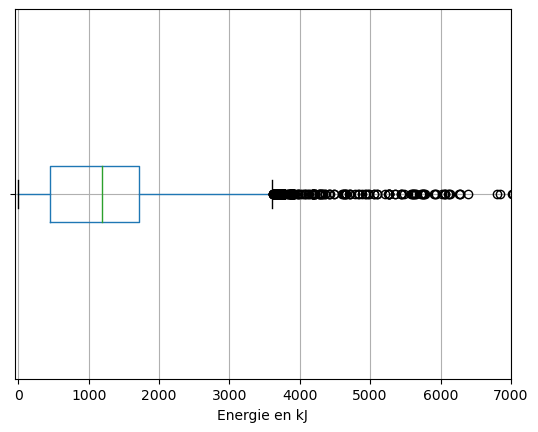

In [48]:
# exploration des outliers max en énergie
data_drop_nrj.boxplot(column="energy_100g", vert=False, showfliers=True)
plt.xlabel("Energie en kJ")
plt.yticks([1], [''])
plt.xlim((-50, 7000))
plt.show()

La valeur maximale pour la valeur énergétique est de 3700 kJ. Toute valeur supérieure est calée à 3700.

In [49]:
# ajustement de la valeur énergétique à son maximum 3700
energy_max = 3700
nb_energy_sup_max = len(data_drop_nrj.loc[data_drop_nrj["energy_100g"]>energy_max, :])
print("Nous modifions la valeur de l'énergie pour", nb_energy_sup_max, "lignes, soit", round(nb_energy_sup_max/len(raw_data)*100, 2), "% du dataset.")
data_drop_nrj.loc[data_drop_nrj["energy_100g"]>energy_max, "energy_100g"] = energy_max

Nous modifions la valeur de l'énergie pour 442 lignes, soit 0.14 % du dataset.


In [50]:
print("Le dataset après le traitement des valeurs manquantes et des outliers présente", data_drop_nrj.shape[0], "lignes et", data_drop_nrj.shape[1], "colonnes")

Le dataset après le traitement des valeurs manquantes et des outliers présente 221042 lignes et 38 colonnes


### d) Suppression lignes dupliquées

Maintenant que nous avons fait tous les traitements de réduction, de sélection et d'ajustement de données, il nous reste à supprimer les valeurs dupliquées. Pour notre modèle, ce qui nous intéresse est de supprimer les lignes dont les variables numériques sont identiques. En effet, des doublons existent avec les mêmes valeurs mais des noms de produit différents.

In [51]:
# identification et suppressions des lignes dupliquées
nb_lignes_dupli_num = data_drop_nrj[data_num.columns].duplicated().sum()
print("Il y a", nb_lignes_dupli_num, "lignes dupliquées dans ce dataset, soit", round(nb_lignes_dupli_num/len(data_drop_nrj)*100, 1), "% du dataset.")
data_dupli_drop = data_drop_nrj.drop_duplicates(subset=data_num.columns).reset_index(drop=True)

Il y a 40858 lignes dupliquées dans ce dataset, soit 18.5 % du dataset.


In [52]:
print("Après suppression des lignes dupliquées, le dataset d'étude présente", data_dupli_drop.shape[0], "lignes et", data_dupli_drop.shape[1], "colonnes.")

Après suppression des lignes dupliquées, le dataset d'étude présente 180184 lignes et 38 colonnes.


***
# IV) Compréhension du dataset

## 1) Shape du dataset d'étude

In [53]:
# Bilan sur le dataset d'étude
data = data_dupli_drop
print("Notre dataset d'étude présente", data.shape[0], "lignes et", data.shape[1], "colonnes")
print("Par rapport à notre dataset brut, on a gardé", round(data.shape[0]/raw_data.shape[0]*100, 2), "% de lignes et", round(data.shape[1]/raw_data.shape[1]*100, 2), "% de colonnes.")
print("Par rapport à notre dataset brut, on a supprimé", round((1-data.shape[0]/raw_data.shape[0])*100, 2), "% de lignes et", round((1-data.shape[1]/raw_data.shape[1])*100, 2), "% de colonnes.")

Notre dataset d'étude présente 180184 lignes et 38 colonnes
Par rapport à notre dataset brut, on a gardé 56.18 % de lignes et 23.46 % de colonnes.
Par rapport à notre dataset brut, on a supprimé 43.82 % de lignes et 76.54 % de colonnes.


In [54]:
# On regarde la répartition des colonnes en fonction de leur type
data_num, data_categ = split_data_num_categ(data)

Voici la répartition des colonnes par type de données :
numeric : 35 colonnes.
category : 3 colonnes.
boolean : 0 colonnes.
datetime : 0 colonnes.
deltatime : 0 colonnes.


## 2) Analyse univariée

Regardons la répartition des différentes variables disponibles dans notre dataset. Il y a tout d'abord des variables notables telles que `nutrition-score-fr_100g`, `energy_100g` et `carbohydrates_100g`.

moyenne :  9.265289925853573
médiane :  10.0
mode :  0    0.0
Name: nutrition-score-fr_100g, dtype: float64
min :  -15.0
max :  40.0
quartiles :  [1.0, 16.0]
variance :  79.62423897941824
écart-type :  8.923241506281125
coefficient de variation :  0.9630828152912941
skewness :  0.1201424269238245
kurtosis :  -0.9841199313648099


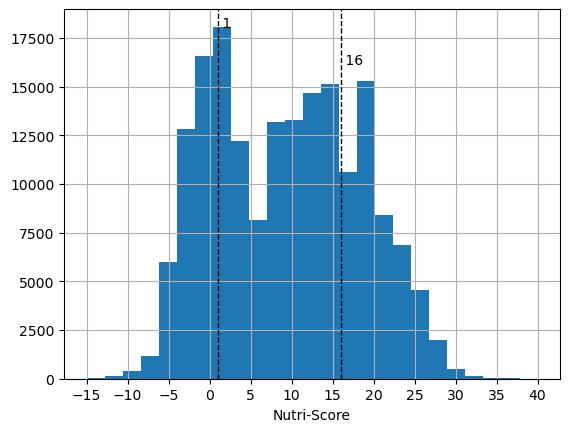

In [55]:
# Etude du Nutri-Score
# mesures de tendances centrales
print("moyenne : ", data["nutrition-score-fr_100g"].mean())
print("médiane : ", data["nutrition-score-fr_100g"].median())
print("mode : ", data["nutrition-score-fr_100g"].mode())
print("min : ", data["nutrition-score-fr_100g"].min())
print("max : ", data["nutrition-score-fr_100g"].max())
quartiles = [np.percentile(data["nutrition-score-fr_100g"], p) for p in [25, 75]]
print("quartiles : ", quartiles)
# mesures de dispersion
print("variance : ", data["nutrition-score-fr_100g"].var(ddof=0))
print("écart-type : ", data["nutrition-score-fr_100g"].std(ddof=0))
print("coefficient de variation : ", data["nutrition-score-fr_100g"].std(ddof=0)/data["nutrition-score-fr_100g"].mean())
# mesures de forme
print("skewness : ", data["nutrition-score-fr_100g"].skew())
print("kurtosis : ", data["nutrition-score-fr_100g"].kurtosis())
data["nutrition-score-fr_100g"].hist(bins=25)
plt.xlabel("Nutri-Score")
# pour tracer les 1er et 3ème quartiles
min_ylim, max_ylim = plt.ylim()
plt.xticks(np.arange(-15, 41, 5))
plt.axvline(quartiles[0], color='k', linestyle='dashed', linewidth=1)
plt.text(quartiles[0], max_ylim*0.95, ' {:.0f}'.format(quartiles[0]))
plt.axvline(quartiles[1], color='k', linestyle='dashed', linewidth=1)
plt.text(quartiles[1], max_ylim*0.85, ' {:.0f}'.format(quartiles[1]))
plt.show()

In [56]:
# Nutri-Score > 25
nb_ns_sup = data.loc[data["nutrition-score-fr_100g"]>=25,:]
print("Les produits ayant un Nutri-Score de plus de 25 représentent", round(len(nb_ns_sup)/len(data)*100, 1), "% du total.")
# Nutri-Score < -5
nb_ns_inf = data.loc[data["nutrition-score-fr_100g"]<=-5,:]
print("Les produits ayant un Nutri-Score de moins de -5 représentent", round(len(nb_ns_inf)/len(data)*100, 1), "% du total.")

Les produits ayant un Nutri-Score de plus de 25 représentent 4.0 % du total.
Les produits ayant un Nutri-Score de moins de -5 représentent 4.3 % du total.


moyenne :  1171.690766316654
médiane :  1151.0
mode :  0    2092.0
Name: energy_100g, dtype: float64
min :  0.0
max :  3700.0
quartiles :  [473.0, 1730.0]
variance :  562069.7153020618
écart-type :  749.7130886559617
coefficient de variation :  0.6398557624660403
skewness :  0.30882269059192213
kurtosis :  -0.6803970748910553


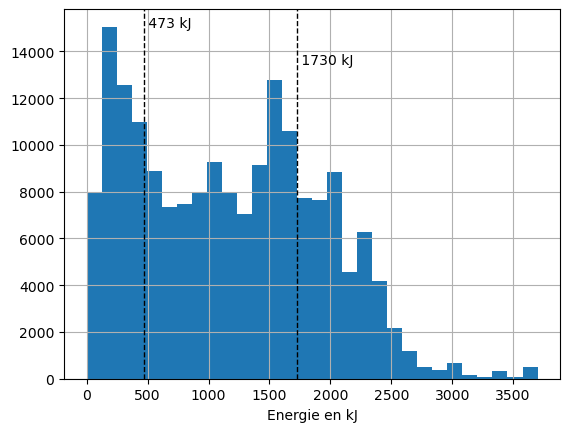

In [57]:
# Etude de l'énergie
# mesures de tendances centrales
print("moyenne : ", data["energy_100g"].mean())
print("médiane : ", data["energy_100g"].median())
print("mode : ", data["energy_100g"].mode())
print("min : ", data["energy_100g"].min())
print("max : ", data["energy_100g"].max())
quartiles = [np.percentile(data["energy_100g"], p) for p in [25, 75]]
print("quartiles : ", quartiles)
# mesures de dispersion
print("variance : ", data["energy_100g"].var(ddof=0))
print("écart-type : ", data["energy_100g"].std(ddof=0))
print("coefficient de variation : ", data["energy_100g"].std(ddof=0)/data["energy_100g"].mean())
# mesures de forme
print("skewness : ", data["energy_100g"].skew())
print("kurtosis : ", data["energy_100g"].kurtosis())
data["energy_100g"].hist(bins=30)
plt.xlabel("Energie en kJ")
# pour tracer les 1er et 3ème quartiles
min_ylim, max_ylim = plt.ylim()
plt.axvline(quartiles[0], color='k', linestyle='dashed', linewidth=1)
plt.text(quartiles[0], max_ylim*0.95, ' {:.0f} kJ'.format(quartiles[0]))
plt.axvline(quartiles[1], color='k', linestyle='dashed', linewidth=1)
plt.text(quartiles[1], max_ylim*0.85, ' {:.0f} kJ'.format(quartiles[1]))
plt.show()

In [58]:
# énergie > 2500 kJ
nb_nrj_sup = data.loc[data["energy_100g"]>=2500,:]
print("Les produits ayant une valeur énergétique de plus de 2500 kJ représentent", round(len(nb_nrj_sup)/len(data)*100, 1), "% du total.")
# énergie < 250 kJ
nb_nrj_inf = data.loc[data["energy_100g"]<=250,:]
print("Les produits ayant une valeur énergétique de moins de 250 kJ représentent", round(len(nb_nrj_inf)/len(data)*100, 1), "% du total.")

Les produits ayant une valeur énergétique de plus de 2500 kJ représentent 3.1 % du total.
Les produits ayant une valeur énergétique de moins de 250 kJ représentent 13.0 % du total.


moyenne :  31.426242223948858
médiane :  22.12
mode :  0    0.0
Name: carbohydrates_100g, dtype: float64
min :  0.0
max :  100.0
quartiles :  [6.67, 56.0]
variance :  748.9804834931633
écart-type :  27.36750780566552
coefficient de variation :  0.8708488788013504
skewness :  0.5291394302160471
kurtosis :  -1.070629313135793


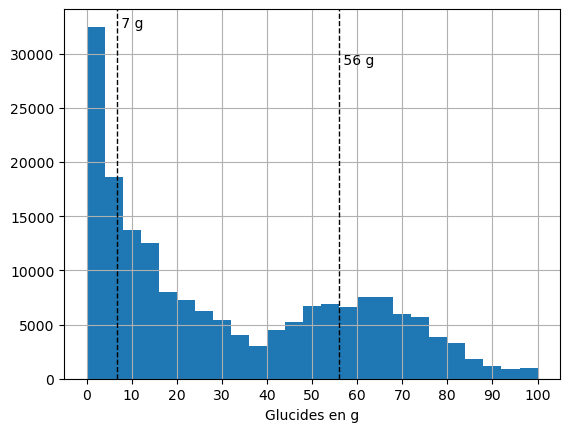

In [59]:
# Etude des glucides
# mesures de tendances centrales
print("moyenne : ", data["carbohydrates_100g"].mean())
print("médiane : ", data["carbohydrates_100g"].median())
print("mode : ", data["carbohydrates_100g"].mode())
print("min : ", data["carbohydrates_100g"].min())
print("max : ", data["carbohydrates_100g"].max())
quartiles = [np.percentile(data["carbohydrates_100g"], p) for p in [25, 75]]
print("quartiles : ", quartiles)
# mesures de dispersion
print("variance : ", data["carbohydrates_100g"].var(ddof=0))
print("écart-type : ", data["carbohydrates_100g"].std(ddof=0))
print("coefficient de variation : ", data["carbohydrates_100g"].std(ddof=0)/data["carbohydrates_100g"].mean())
# mesures de forme
print("skewness : ", data["carbohydrates_100g"].skew())
print("kurtosis : ", data["carbohydrates_100g"].kurtosis())
data["carbohydrates_100g"].hist(bins=25)
plt.xlabel("Glucides en g")
# pour tracer les 1er et 3ème quartiles
min_ylim, max_ylim = plt.ylim()
plt.xticks(np.arange(0, 101, 10))
plt.axvline(quartiles[0], color='k', linestyle='dashed', linewidth=1)
plt.text(quartiles[0], max_ylim*0.95, ' {:.0f} g'.format(quartiles[0]))
plt.axvline(quartiles[1], color='k', linestyle='dashed', linewidth=1)
plt.text(quartiles[1], max_ylim*0.85, ' {:.0f} g'.format(quartiles[1]))
plt.show()

In [60]:
# glucides < 4 g
nb_carbo_inf = data.loc[data["carbohydrates_100g"]<=4,:]
print("Les produits ayant une teneur en glucides de moins de 4g représentent", round(len(nb_carbo_inf)/len(data)*100, 1), "% du total.")
# glucides > 80 g
nb_carbo_sup = data.loc[data["carbohydrates_100g"]>=80,:]
print("Les produits ayant une teneur en glucides de plus de 80g représentent", round(len(nb_carbo_sup)/len(data)*100, 1), "% du total.")
# glucides > 40g & < 80 g
nb_carbo_inter = data.loc[(data["carbohydrates_100g"]<=80) & (data["carbohydrates_100g"]>=40),:]
print("Les produits ayant une teneur en glucides comprise entre 40g et 80g représentent", round(len(nb_carbo_inter)/len(data)*100, 1), "% du total.")

Les produits ayant une teneur en glucides de moins de 4g représentent 18.4 % du total.
Les produits ayant une teneur en glucides de plus de 80g représentent 4.5 % du total.
Les produits ayant une teneur en glucides comprise entre 40g et 80g représentent 34.3 % du total.


Concernant toutes les autres variables numériques, les tendances sont similaires. Ils se répartissent principalement autour de la valeur 0. Ceci est dû à la quantité de valeurs manquantes.

Pour les variables catégorielles restantes, nous pouvons observer une représentation pour le Nutri-Grade.

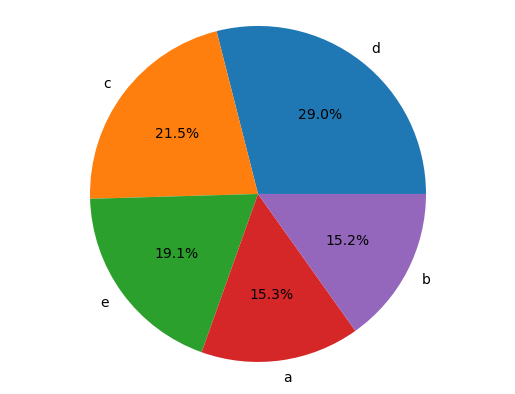

In [61]:
# répartition des Nutri-Grade dans le dataset
temp_val_count = data["nutrition_grade_fr"].value_counts(normalize=True)
temp_val_count.plot(kind='pie', autopct=show_perc, labels=show_labels(temp_val_count), label='')
plt.axis('equal')
plt.show()

In [62]:
# majorité des produits
maj_produits = data.loc[(data["nutrition_grade_fr"]=="d") | (data["nutrition_grade_fr"]=="c") | (data["nutrition_grade_fr"]=="e"),:]
print("Les principales notes de produits représentent ", round(len(maj_produits)/len(data)*100, 1), " % du total.")

Les principales notes de produits représentent  69.6  % du total.


***
# V) Analyse de la problématique

Voilà notre problématique : créer une application pour qualifier la qualité des produits.  
Deux questions principales découlent de cette problématique : 
 - Quel modèle performant utiliser ?
 - Quel design pour notre application ?

Nous pouvons répondre à ces questions en étudiant différents aspects : 
 - le choix du modèle (Régression Linéaire ou KNN)
 - la performance du modèle (paramètre du modèle et données d’entrée)
 - le choix de variables pertinentes (pour le modèle et l’utilisateur)
 - la réduction du nombre de colonnes (pour le modèle et l’attrait de l’application)

Selon les lois européennes, voici la liste des variables étant obligatoirement sur une étiquette de produit : 
- `energy_100g` : valeur énergétique du produit en kJ pour 100g
- `fat_100g` : teneur en matière grasse pour 100g
- `saturated-fat_100g` : teneur en matière grasse saturée pour 100g
- `carbohydrates_100g` : teneur en glucide pour 100g
- `sugars_100g` : teneur en sucre pour 100g
- `proteins_100g` : teneur en protéine pour 100g
- `salt_100g` : teneur en sel pour 100g  

In [63]:
# colonnes de type numérique ne contenant pas la target Nutri-Score
col_num_wo_nutriscore = [x for x in data_num.columns if x != "nutrition-score-fr_100g"]
# colonnes contenant les teneurs en vitamine pour 100g
col_vitamins = ['vitamin-a_100g', 'vitamin-d_100g', 'vitamin-e_100g', 'vitamin-k_100g', 'vitamin-c_100g', 'vitamin-b1_100g',
                'vitamin-b2_100g', 'vitamin-pp_100g', 'vitamin-b6_100g', 'vitamin-b9_100g', 'vitamin-b12_100g', 'biotin_100g',
                 'pantothenic-acid_100g']
col_remain_vitamins = [x for x in col_vitamins if x in data.columns]
col_num_wo_vitamins = [x for x in col_num_wo_nutriscore if x not in col_remain_vitamins]

## 1) Corrélation entre le Nutri-Score et le Nutri-Grade (ANOVA)

Comme nous avons vu plus haut, nous avons deux colonnes qui peuvent servir de target pour notre étude : `nutrition-score-fr_100g` et `nutrition_grade_fr`. Vérifions d'abord qu'il sa'git bien de deux variables corrélées par la méthode ANOVA.

Correlation de 0.927 . Les 2 variables sont hautement corrélées.


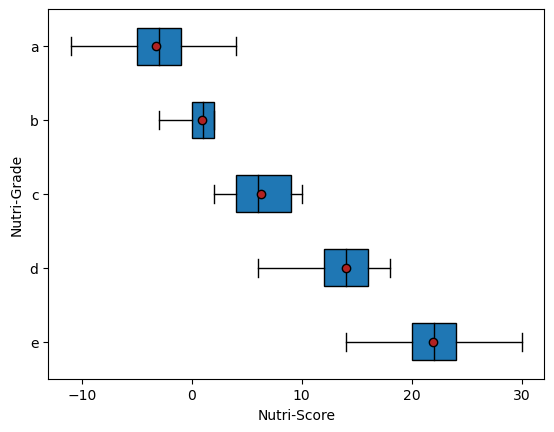

In [64]:
X = "nutrition_grade_fr" # qualitative
Y = "nutrition-score-fr_100g" # quantitative
print("Correlation de", round(eta_squared(data[X],data[Y]), 3), ". Les 2 variables sont hautement corrélées.")
modalites = sorted(data[X].unique(), reverse=True)
groupes = []
for m in modalites:
    groupes.append(data[data[X]==m][Y])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.xlabel("Nutri-Score")
plt.ylabel("Nutri-Grade")
plt.show()

Nous confirmons qu'il y a bien une corrélation forte entre le Nutri-Score et le Nutri-Grade.

## 2) Corrélation entre les variables numériques

Faisons une analyse à l'aide d'une heatmap maintenant que nous avons beaucoup moins de variables à étudier. C'est plus lisible et cela nous permet donc de distinguer les plus fortes corrélations.  
NB : par souci de lisibilité sur le graphique, nous retirons les vitamines car elles ne présentent pas de corrélation particulière entre elles et avec les autres variables.

<AxesSubplot: >

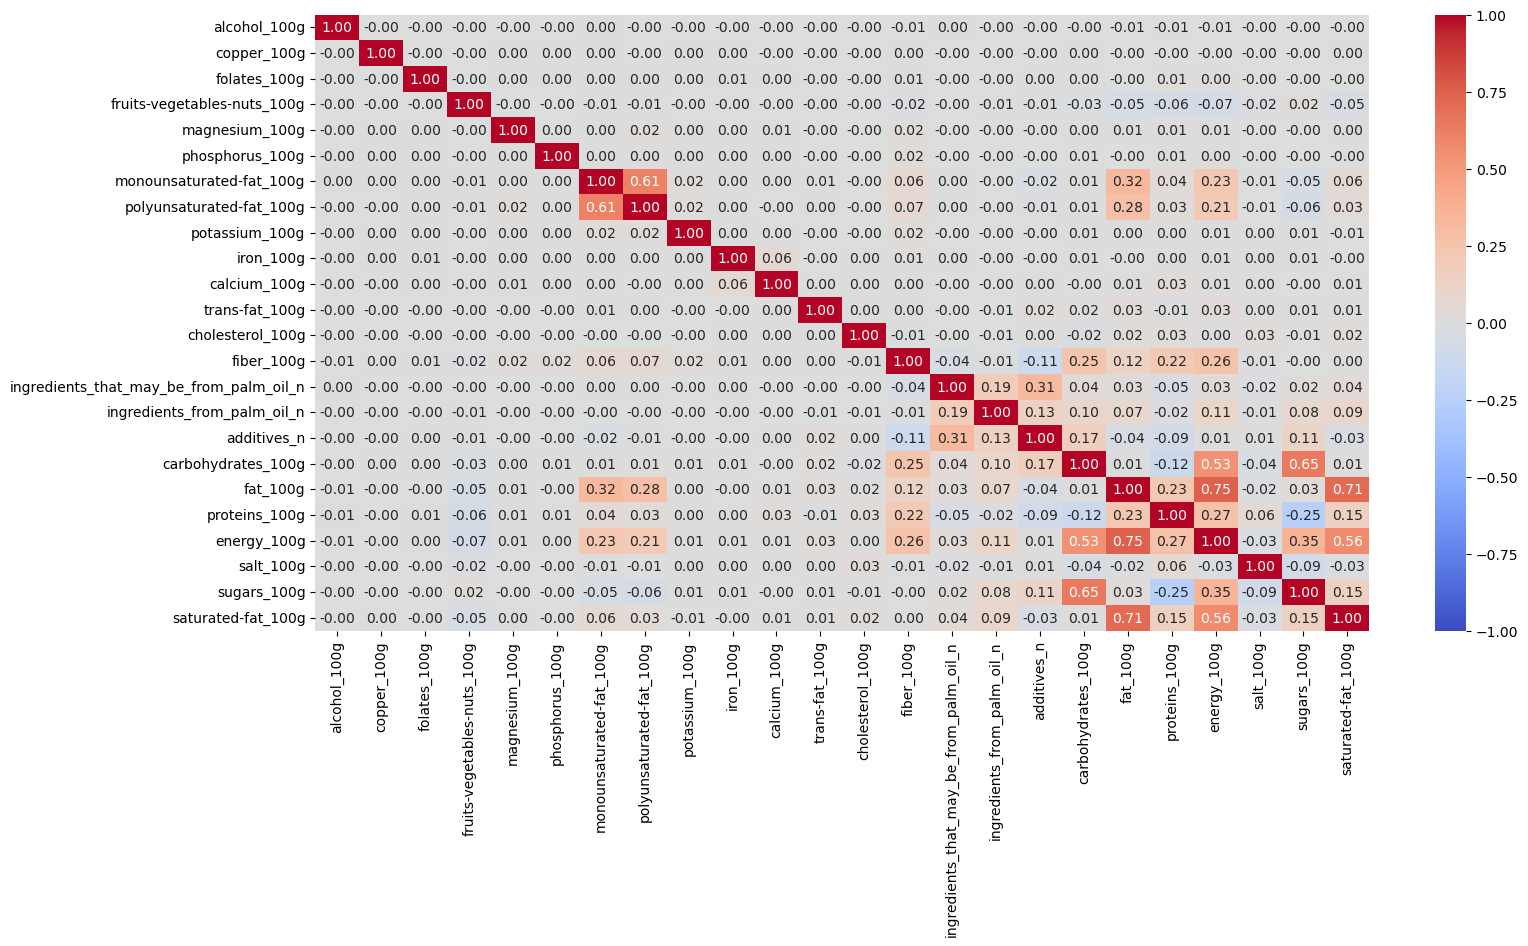

In [65]:
# On prend toutes les variables numériques, exceptée le Nutri-Score
corr = data[col_num_wo_vitamins].corr()
fig, ax = pyplot.subplots(figsize=(17, 8))
sns.heatmap(corr, ax=ax, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

On peut distinguer plusieurs corrélations : 
 - `fat_100g` et `saturated-fat_100g` (puisque l'un est un des composant de l'autre) 0.71
 - `carbohydrates_100g` et `sugars_100g` (puisque l'un est un des composant de l'autre) 0.65
 - `energy_100g` avec dans l'ordre d'importance `fat_100g`, `saturated-fat_100g`, `carbohydrates_100g`, `sugars_100g` et `proteins_100g` (puisque que la valeur énergétique est calculée à partir des teneur en protéines, glucides et matières grasses)

Il y a certes des corrélations fortes mais pas assez pour supprimer directement une des valeurs.  
Nous allons donc toutes les conserver dans un premier temps. Puis au moment de tester les performances de nos modèles, nous testerons ces variables indépendamment.

Ces corrélations sont trop faibles pour que nous puissions en déduire quoi que ce soit ou faire de nouvelles approximations.

## 3) Corrélations entre le Nutri-Score et les autres variables

On choisit de transformer le Nutri-Grade de valeur en caractère à valeur numérique pour meilleure exploitation sur les graphiques suivants.

In [66]:
# on fait la transcription pour le Nutri-Grade pour passer de lettres à chiffres pour une meilleure exploitation graphique
code = {'a':1, 'b':2, 'c':3, 'd':4, 'e':5}
data['nutrition_grade_fr'] = data['nutrition_grade_fr'].replace(code).astype(np.float64)
col_ns = "nutrition-score-fr_100g"

On va uniquement montrer les représentation en fonction des variables Valeur énergétique et Matières grasses saturées car ce sont les corrélations les plus fortes, plus de 0.6.

Corrélation de Pearson : 0.648
Covariance : 4334.8


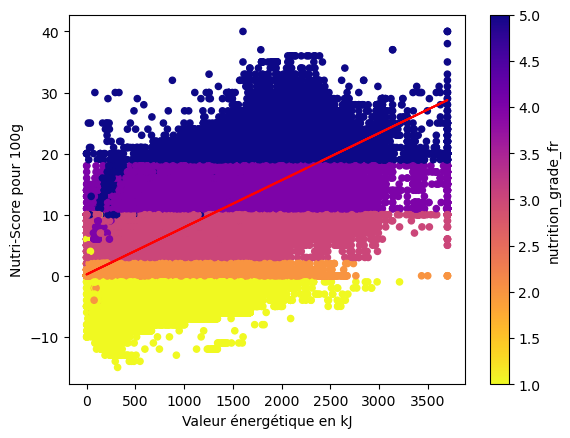

In [67]:
# corrélation entre le Nutri-Score et la valeur énergétique
corr_pears = st.pearsonr(data["energy_100g"],data[col_ns])[0]
print("Corrélation de Pearson :", round(corr_pears, 3))
print("Covariance :", round(np.cov(data["energy_100g"],data[col_ns],ddof=0)[1,0], 1))
# plt.plot(data[col],data[nutri_score],'o')
data.plot.scatter("energy_100g", col_ns, c="nutrition_grade_fr", colormap='plasma_r')
m, b = np.polyfit(data["energy_100g"],data[col_ns], 1)
plt.plot(data["energy_100g"], m*data["energy_100g"]+b, color='red')
plt.xlabel("Valeur énergétique en kJ")
plt.ylabel("Nutri-Score pour 100g")
plt.show()

Corrélation de Pearson : 0.63
Covariance : 41.4


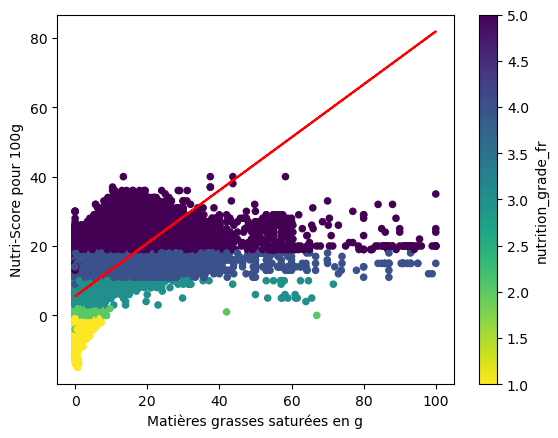

In [68]:
# corrélation entre le Nutri-Score et les matières grasses saturées
corr_pears = st.pearsonr(data["saturated-fat_100g"],data[col_ns])[0]
print("Corrélation de Pearson :", round(corr_pears, 3))
print("Covariance :", round(np.cov(data["saturated-fat_100g"],data[col_ns],ddof=0)[1,0], 1))
# plt.plot(data[col],data[nutri_score],'o')
data.plot.scatter("saturated-fat_100g", col_ns, c="nutrition_grade_fr", colormap='viridis_r')
m, b = np.polyfit(data["saturated-fat_100g"],data[col_ns], 1)
plt.plot(data["saturated-fat_100g"], m*data["saturated-fat_100g"]+b, color='red')
plt.xlabel("Matières grasses saturées en g")
plt.ylabel("Nutri-Score pour 100g")
plt.show()

Il n'y a que 2 variables ayant un coefficient de Pearson supérieur à 0.6 montrant un tant soit peu de corrélation.

## 4) Réduction du nombre de colonnes (ACP)

Il reste encore beaucoup de colonnes numériques. Nous pouvons encore en réduire le nombre en passant par la méthode du PCA.  
C'est possible de l'utiliser car nous avons au préalable traité les valeurs manquantes et les outliers. En effet, la méthode du PCA n'accepte pas les premiers et n'est pas robuste aux seconds.

L'échantillon présente 180184 lignes et 34 colonnes
Une méthode consiste à dire que l'on garde uniquement les valeurs propres supérieures à 1.
Ici, la méthode des valeurs propres nous demande de garder 24 composantes.
La méthode principale consiste à dire que l'on garde uniquement les composantes qui regroupent 95% des variables.
Ici, la méthode des 95% d'inertie nous demande de garder 28 composantes.


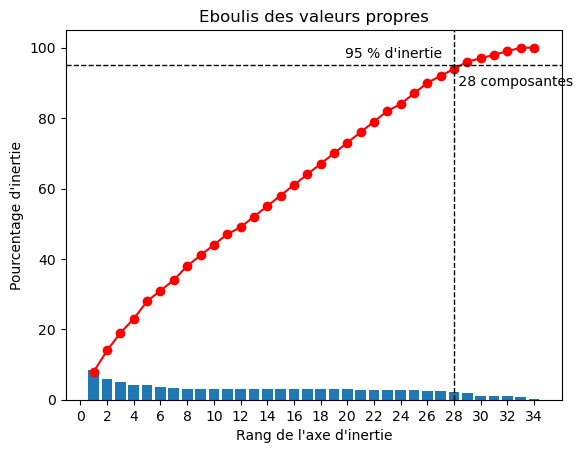

In [69]:
# tracé de l'éboulis des valeurs propres
pca = compute_pca(data[col_num_wo_nutriscore], 34)

On voit sur la représentation d'éboulis des valeurs propres que 28 variables sont nécessaires pour regrouper 95% des variables. Nous devons effectuer une autre approche en regardans directement les coefficients de corrélation entre les composantes et les variables.

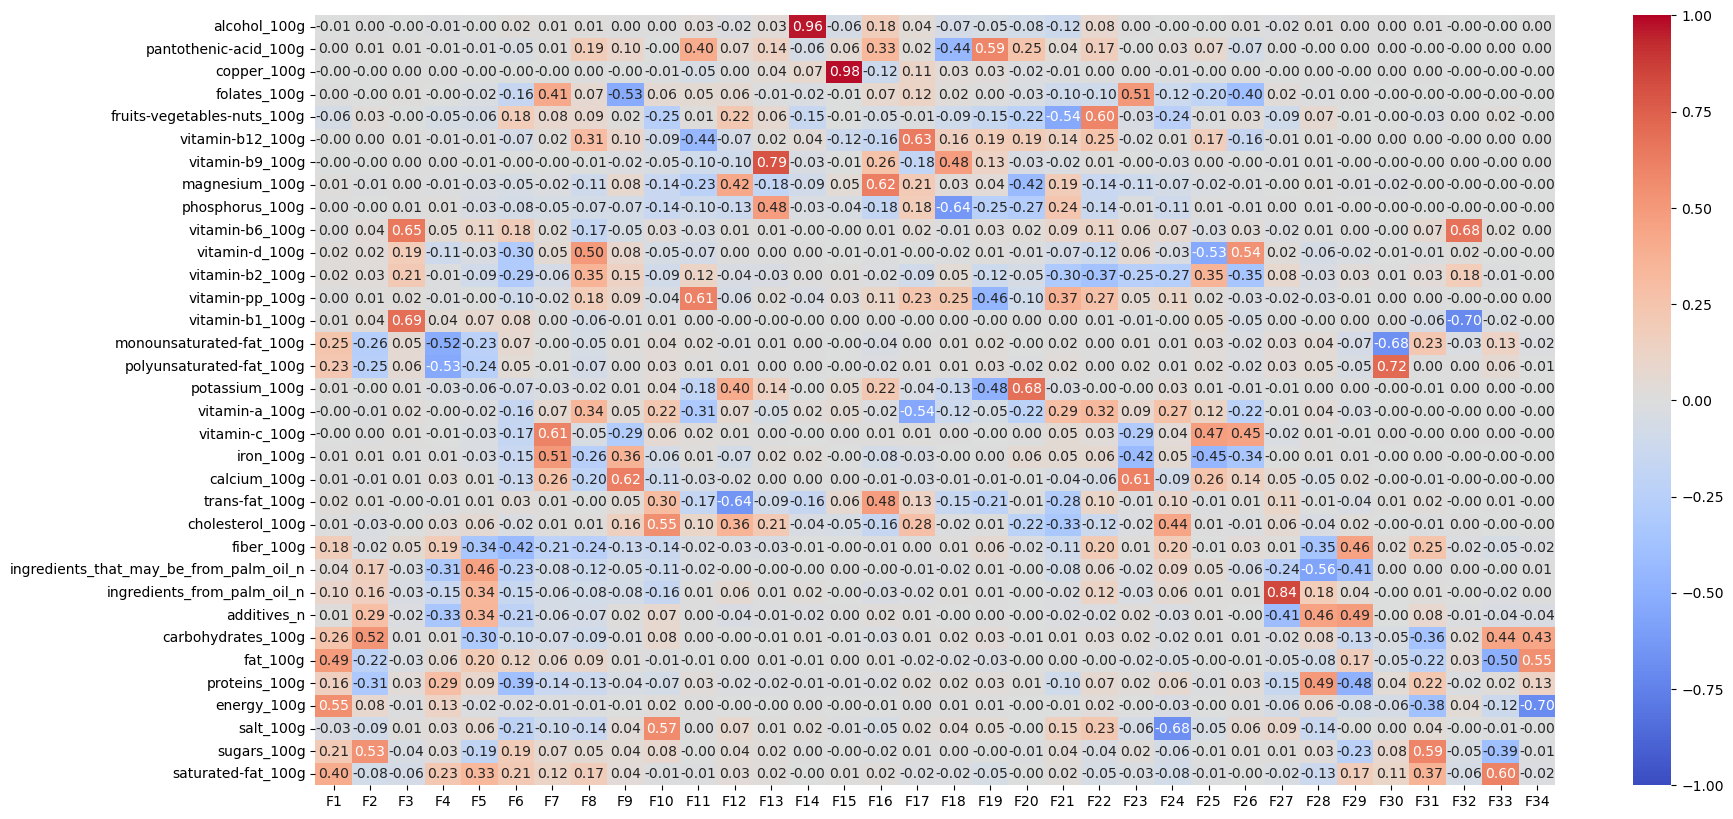

In [70]:
# heatmap de corrlation entre les variables et les composantes
pcs = show_components_heatmap(data[col_num_wo_nutriscore], pca)

In [71]:
# on parcourt toutes les lignes et on relève toutes les variables ayant une "importance" (> 0.65) dans une composante
reduc_var = compute_components(pcs, threshold=0.65)

vitamin-b6_100g : 0.6520985374802399
vitamin-b1_100g : 0.688151345260156
vitamin-b9_100g : 0.7908979511578269
alcohol_100g : 0.9617193988659881
copper_100g : 0.9800568039889425
potassium_100g : 0.6848473658387604
salt_100g : -0.6815016630332026
ingredients_from_palm_oil_n : 0.8373780909342992
monounsaturated-fat_100g : -0.6755887076619728
polyunsaturated-fat_100g : 0.7170380638605652
vitamin-b6_100g : 0.6769148127459204
vitamin-b1_100g : -0.7047714651467738
energy_100g : -0.702664016332196
Il y a 11 variables ayant un impact conséquent sur les composantes.
Voici la liste : ['potassium_100g', 'monounsaturated-fat_100g', 'ingredients_from_palm_oil_n', 'vitamin-b6_100g', 'copper_100g', 'polyunsaturated-fat_100g', 'salt_100g', 'vitamin-b9_100g', 'alcohol_100g', 'energy_100g', 'vitamin-b1_100g']


Cette approche technique nous renvoie une liste de variables ayant un fort impact dans le dataset. Cependant, notre approche métier nous permet de conclure les faits suivants :
 - l’utilisateur aura à sa disposition les variables obligatoires sur l’étiquette
 - si un certains nombre de vitamines sont présentes, l’utilisateur sera étonné de ne voir que celles-ci
 - il y a également des variables que je trouve pertinentes. J’envisage de faire des tests sur les performances avec ces variables supplémentaires afin de décider si je dois les conserver ou non

Les listes col_mandatory_altered et col_perti ont été élaborées suite à l'étude des performances des modèles plus bas.

In [72]:
col_mandatory_altered = ['energy_100g', 'saturated-fat_100g', 'sugars_100g', 'proteins_100g', 'salt_100g']
reduc_var_altered = [x for x in reduc_var if x not in ["monounsaturated-fat_100g", "polyunsaturated-fat_100g"]]
col_perti_perf = ["fiber_100g", "fruits-vegetables-nuts_100g", "additives_n"]
col_perti_altered = ["fiber_100g", "fruits-vegetables-nuts_100g"]
col_num_to_keep = ["nutrition-score-fr_100g"] + reduc_var_altered + col_mandatory_altered + col_perti_altered + col_remain_vitamins
col_num_to_keep = list(set(col_num_to_keep))
col_to_keep = col_num_to_keep + data_categ.columns.values.tolist()
print("Après traitement pas la méthode du PCA, nous avons sélectionné", len(col_num_to_keep), "colonnes de type numérique, dont le Nutri-Score, pour notre étude.")

Après traitement pas la méthode du PCA, nous avons sélectionné 22 colonnes de type numérique, dont le Nutri-Score, pour notre étude.


In [73]:
# export du dataframe en fichier csv
col_to_proto = [x for x in col_num_to_keep if x != "nutrition-score-fr_100g"] + ["nutrition_grade_fr"]
print("Pour notre prototype, nous avons un total de", len(col_to_proto), "colonnes dont le Nutri-Grade.")
data[col_to_proto].to_csv("input_knn.csv", sep='\t', encoding='utf-8')

Pour notre prototype, nous avons un total de 22 colonnes dont le Nutri-Grade.


# VI) Etudes de modèles pour qualifier la qualité des produits

Voici le protocole concernant l’étude des modèles : 
 - sélection des modèles possibles (Régression Linéaire et KNN)
 - sélection des targets pour chaque modèle (Nutri-Score et Nutri-Grade)
 - fractionnement de l’échantillon en 2 parties : training set 80% et testing set 20% pour la qualité du modèle
 - test des variables sélectionnées

Ce protocole va nous permettre de choisir le modèle le plus performant pour notre application.

In [74]:
# on définit les valeurs et les targets pour chaque modèle
X = data[data_num.columns]
y_reg_lin = data["nutrition-score-fr_100g"]
y_knn = data["nutrition_grade_fr"]

In [75]:
# on définit les variables qui seront utiliser pour les modèles
col_num_wo_nutriscore = [x for x in col_num_to_keep if x != "nutrition-score-fr_100g"]
col_to_test_perf = reduc_var + col_mandatory + col_perti_perf + col_remain_vitamins
col_to_test_perf = list(set(col_to_test_perf))
col_perf1_wo_add = [x for x in col_to_test_perf if x != "additives_n"]
col_perf2_wo_carbo = [x for x in col_perf1_wo_add if x != "carbohydrates_100g"]
col_perf3_wo_fat = [x for x in col_perf2_wo_carbo if x not in ["fat_100g", "monounsaturated-fat_100g", "polyunsaturated-fat_100g"]]
print("Suite à la sélection précédente, nous avons", len(col_to_test_perf), "colonnes nous permettant de tester les performances des modèles.")

Suite à la sélection précédente, nous avons 26 colonnes nous permettant de tester les performances des modèles.


### 1) Application de la Régression Linéaire

In [76]:
# on sépare l'échantillon en données d'entraînement et données de test à hauteur de 80/20%
X_train, X_test, y_train, y_test = train_test_split(X, y_reg_lin, test_size=0.2, random_state=101)
model = LinearRegression()
for col_grp in [col_to_test_perf, col_perf1_wo_add, col_perf2_wo_carbo, col_perf3_wo_fat]:
    model.fit(X_train[col_grp],y_train)
    predictions = model.predict(X_test[col_grp])
    print("Performance de prédiction de la Régression Linéaire :", round(r2_score(y_test, predictions)*100, 1), "%")

Performance de prédiction de la Régression Linéaire : 71.4 %
Performance de prédiction de la Régression Linéaire : 70.4 %
Performance de prédiction de la Régression Linéaire : 70.3 %
Performance de prédiction de la Régression Linéaire : 69.6 %


### 2) Application du K plus proches voisins (KNN)

In [77]:
# on sépare l'échantillon en données d'entraînement et données de test à hauteur de 80/20%
X_train, X_test, y_train, y_test = train_test_split(X, y_knn, test_size=0.2, random_state=101)
for col_grp in [col_to_test_perf, col_perf1_wo_add, col_perf2_wo_carbo, col_perf3_wo_fat]:
    model = neighbors.KNeighborsClassifier(n_neighbors=6, weights='distance', p=1, leaf_size=20, metric='minkowski')
    model.fit(X_train[col_grp], y_train)
    print("Performance de prédiction du KNN :", round(model.score(X_test[col_grp], y_test)*100, 1), "%")

Performance de prédiction du KNN : 75.1 %
Performance de prédiction du KNN : 75.7 %
Performance de prédiction du KNN : 77.1 %
Performance de prédiction du KNN : 78.5 %


Le KNN est plus performant que la Régression Linéaire dans notre étude. Nous allons vérifier le nombre K optimal.

In [78]:
# tracé des performances du KNN en fonction du nombre de plus proches voisins
performances = []
max_k = 12
for k in range(2,max_k):
    knn = neighbors.KNeighborsClassifier(k, weights='distance', p=1, leaf_size=20, metric='minkowski')
    performances.append(100*knn.fit(X_train[col_num_wo_nutriscore], y_train).score(X_test[col_num_wo_nutriscore], y_test))

In [79]:
plt.plot(range(2,max_k), performances, 'o-')
plt.xlabel("Valeur de K")
plt.ylabel("Taux de prédiction (%)")
plt.grid(axis="x")
plt.xticks(np.arange(2, max_k, 1))
plt.show()

On peut voir un optimum de performance pour k=6.

***
# VII) Présentation du prototype

In [82]:
from ipywidgets import interact, Layout, FloatSlider, IntProgress
style = {'description_width': 'initial'}
layout=Layout(width='70%', height='auto')
# data_proto = pd.read_csv("input_knn.csv", encoding='utf-8', sep='\t', index_col=0)
col_num_wo_nutrigrade = [x for x in col_perf3_wo_fat if x != "nutrition_grade_fr"]

@interact
def compute_score(
    vit_a=FloatSlider(description="Vitamines A", min=0, max=1000, value=0, style=style, layout=layout),
    vit_c=FloatSlider(description="Vitamines C", min=0, max=1000, value=0, style=style, layout=layout),
    vit_d=FloatSlider(description="Vitamines D", min=0, max=1000, value=0, style=style, layout=layout),
    vit_pp=FloatSlider(description="Vitamines PP", min=0, max=1000, value=0, style=style, layout=layout),
    vit_b1=FloatSlider(description="Vitamines B1", min=0, max=1000, value=0, style=style, layout=layout),
    vit_b2=FloatSlider(description="Vitamines B2", min=0, max=1000, value=0, style=style, layout=layout),
    vit_b6=FloatSlider(description="Vitamines B6", min=0, max=1000, value=0, style=style, layout=layout),
    vit_b9=FloatSlider(description="Vitamines B9", min=0, max=1000, value=0, style=style, layout=layout),
    vit_b12=FloatSlider(description="Vitamines B12", min=0, max=1000, value=0, style=style, layout=layout),
    ac_pantho=FloatSlider(description="Acide Pantothénique (B5)", min=0, max=1000, value=0, style=style, layout=layout),
    copper=FloatSlider(description="Cuivre", min=0, max=1000, value=0, style=style, layout=layout),
    potassium=FloatSlider(description="Potassium", min=0, max=1000, value=0, style=style, layout=layout),
    alcohol=FloatSlider(description="Alcool", min=0, max=100, value=0, style=style, layout=layout),
    nb_huile_palm=FloatSlider(description="Nb. ingr. huile de palme", min=0, max=10, value=0, style=style, layout=layout),
    energy=FloatSlider(description="Valeur énergétique", min=0, max=3700, value=0, style=style, layout=layout),
    sat_fat=FloatSlider(description="Matières grasses saturées", min=0, max=100, value=0, style=style, layout=layout),
    sugars=FloatSlider(description="Sucres", min=0, max=100, value=0, style=style, layout=layout),
    proteins=FloatSlider(description="Protéines", min=0, max=100, value=0, style=style, layout=layout),
    salt=FloatSlider(description="Sel", min=0, max=100, value=0, style=style, layout=layout),
    fiber=FloatSlider(description="Fibres", min=0, max=100, value=0, style=style, layout=layout),
    fruits_leg=FloatSlider(description="Part de fruits/légumes/noix", min=0, max=100, value=0, style=style, layout=layout)
):
    data_to_predict = {}
    for col in col_num_wo_nutrigrade:
        data_to_predict[col] = 0
    data_to_predict['energy_100g'] = energy
    data_to_predict['saturated-fat_100g'] = sat_fat
    data_to_predict['sugars_100g'] = sugars
    data_to_predict['proteins_100g'] = proteins
    data_to_predict['salt_100g'] = salt
    data_to_predict['copper_100g'] = copper
    data_to_predict['potassium_100g'] = potassium
    data_to_predict['alcohol_100g'] = alcohol
    data_to_predict['ingredients_from_palm_oil_n'] = nb_huile_palm
    data_to_predict['fiber_100g'] = fiber
    data_to_predict['fruits-vegetables-nuts_100g'] = fruits_leg
    data_to_predict['vitamin-a_100g'] = vit_a
    data_to_predict['vitamin-c_100g'] = vit_c
    data_to_predict['vitamin-d_100g'] = vit_d
    data_to_predict['vitamin-b1_100g'] = vit_b1
    data_to_predict['vitamin-b2_100g'] = vit_b2
    data_to_predict['vitamin-b6_100g'] = vit_b6
    data_to_predict['vitamin-b9_100g'] = vit_b9
    data_to_predict['vitamin-b12_100g'] = vit_b12
    data_to_predict['vitamin-pp_100g'] = vit_pp
    data_to_predict['pantothenic-acid_100g'] = ac_pantho
    df = pd.DataFrame([data_to_predict])
    pred = model.predict(df)
    
    if pred[0] <= 1:
        color = 'green'
    elif pred[0] == 2:
        color = 'lightgreen'
    elif pred[0] == 3:
        color = 'yellow'
    elif pred[0] == 4:
        color = 'orange'
    elif pred[0] == 5:
        color = 'red'
            
    # print(pred)
    result = IntProgress(
        value=pred[0],
        min=0,
        max=5,
        step=1,
        description='Score:',
        bar_style='info',
        style={'bar_color': color},
        orientation='horizontal'
    )
    return result

interactive(children=(FloatSlider(value=0.0, description='Vitamines A', layout=Layout(height='auto', width='70…

Ce prototype présente la liste des différentes variables. Pour chacune, un curseur permet de renseigner une valeur. Le score se calcule en temps réel. Il est matérialisé par la barre de score en bas : 
 - plus elle se remplie, plus le score est mauvais
 - le code couleur est similaire à celui du Nutri-Grade pour donner l'information directement

***
# VIII) Synthèse de l'analyse de données

Suite à toute cette étude, nous pouvons maintenant discuter des améliorations et perspectives.

D’une part, il y a des améliorations à faire sur le design de l’application : 
 - définir une charte graphique
 - travailler sur l’ergonomie
 - ajouter une option pour un définir un régime spécifique (allergènes, sportifs, sans gluten…)
 - ou encore afficher des suggestions de produits alternatifs si la note du produit est faible

D’autre part, il faut également améliorer les performances du modèle. Un taux de prédiction de 78% est assez moyen. J’aurai bien aimé tester d’autres modèles.  
Dans mes recherches, j’ai pu voir que le Nutri-Score dépend d’un certain nombre de variables précises : 
- Valeur énergétique
- Sucres
- Matières grasses saturées
- Sel
- Protéines
- Fibres
- Part de fruits/légumes/noix

Mais surtout que le calcul n’est pas le même en fonction de certaines catégories de produit : 
- Cas général
- Matières grasses ajoutées
- Boissons
- Fromages

Il faudrait donc ajouter le type de produit dans l’algorithme pour améliorer les performances.